In [1]:
from pyspark.sql import SparkSession

In [2]:
# spark = SparkSession.builder.appName("Test").getOrCreate()

In [3]:
# spark.range(10).show()

This works fine so far but, to connect to the database, you need a database driver and they didn't come included in this repo.

Here i wanted to get the MySQL JDBC driver
* i didn't get it to work but one way of doing that would (in theory) be to download the file from here https://dev.mysql.com/downloads/connector/j/ (i placed it under `requirements/mysql-connector-j-9.1.0.jar`). Then need to make it available to the container

    eg. by changing the Dockerfile

    ```Dockerfile
    # Download and install Spark
    RUN curl https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz -o spark-${SPARK_VERSION}-bin-hadoop3.tgz \
    && tar xvzf spark-${SPARK_VERSION}-bin-hadoop3.tgz --directory /opt/spark --strip-components 1 \
    && rm -rf spark-${SPARK_VERSION}-bin-hadoop3.tgz

    # new
    # Add MySQL JDBC driver to the Spark classpath
    COPY requirements/mysql-connector-j-9.1.0.jar /opt/spark/jars/

    FROM spark-base as pyspark
    ```

    and then you'd change the spark-submit call to include it

    eg. on a jupyter notebook,
    ```python
    # Set the environment variable to include the MySQL JDBC JAR
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars file:///opt/spark/jars/mysql-connector-j-9.1.0.jar pyspark-shell'
    ```

    BUT didn't work for me so... Any advice on that is appreciated.

* the way it worked for me, was this

    ```python
    # Set the environment variable to include the MySQL JDBC driver using --packages
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages mysql:mysql-connector-java:8.0.28 pyspark-shell'
    ```

    this will download the package for me at the time the command is issued... it is slower but works at least

    Also, see this

    https://stackoverflow.com/questions/63677107/how-to-set-up-jdbc-driver-for-mysql-in-jupyter-notebook-for-pyspark

In [4]:
from pyspark.sql import SparkSession, DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [5]:
import os

In [6]:
# Set the environment variable to include the MySQL JDBC driver using --packages
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages mysql:mysql-connector-java:8.0.28 pyspark-shell'

In [7]:
spark = SparkSession.builder.appName("MySQL Test").getOrCreate()

your 131072x1 screen size is bogus. expect trouble


25/01/03 14:02:37 WARN Utils: Your hostname, LPT-5CG129083D resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/01/03 14:02:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/devcontainers/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/devcontainers/.ivy2/cache
The jars for the packages stored in: /home/devcontainers/.ivy2/jars
mysql#mysql-connector-java added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ede11084-a863-4f73-b979-be8e0dff76e9;1.0
	confs: [default]
	found mysql#mysql-connector-java;8.0.28 in central
	found com.google.protobuf#protobuf-java;3.11.4 in central
:: resolution report :: resolve 225ms :: artifacts dl 7ms
	:: modules in use:
	com.google.protobuf#protobuf-java;3.11.4 from central in [default]
	mysql#mysql-connector-java;8.0.28 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------------

25/01/03 14:02:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [12]:
mysql_url = "jdbc:mysql://localhost:3307/sakila"

properties = {
    "user": "root",  # Replace with your MySQL username
    "password": "rootpassword",  # Replace with your MySQL password
    "driver": "com.mysql.cj.jdbc.Driver"
}

In [13]:
# Read the data from MySQL tables into Spark DataFrames
df_actor = spark.read.jdbc(mysql_url, "actor", properties=properties)
df_customer = spark.read.jdbc(mysql_url, "customer", properties=properties)
df_film = spark.read.jdbc(mysql_url, "film", properties=properties)

In [14]:
df_actor

DataFrame[actor_id: int, first_name: string, last_name: string, last_update: timestamp]

In [13]:
# Show data
df_actor.show(5)
df_customer.show(5)
df_film.show(5)

+--------+----------+------------+-------------------+
|actor_id|first_name|   last_name|        last_update|
+--------+----------+------------+-------------------+
|       1|  PENELOPE|     GUINESS|2006-02-15 04:34:33|
|       2|      NICK|    WAHLBERG|2006-02-15 04:34:33|
|       3|        ED|       CHASE|2006-02-15 04:34:33|
|       4|  JENNIFER|       DAVIS|2006-02-15 04:34:33|
|       5|    JOHNNY|LOLLOBRIGIDA|2006-02-15 04:34:33|
+--------+----------+------------+-------------------+
only showing top 5 rows

+-----------+--------+----------+---------+--------------------+----------+------+-------------------+-------------------+
|customer_id|store_id|first_name|last_name|               email|address_id|active|        create_date|        last_update|
+-----------+--------+----------+---------+--------------------+----------+------+-------------------+-------------------+
|          1|       1|      MARY|    SMITH|MARY.SMITH@sakila...|         5|  true|2006-02-14 22:04:36|2006-02-1

Examples...

In [14]:
# Filtering Customers Who Have Rented a Film

# Load the rental and payment tables
df_rental = spark.read.jdbc(mysql_url, "rental", properties=properties)
df_payment = spark.read.jdbc(mysql_url, "payment", properties=properties)

df_rental.show(5)
df_payment.show(5)

# Join customer, rental, and payment data to analyze customer activity
df_customer_rentals = df_customer.join(df_rental, df_customer.customer_id == df_rental.customer_id) \
                                 .join(df_payment, df_rental.rental_id == df_payment.rental_id)

# Show customer rental and payment data
df_customer_rentals.show(5)

+---------+-------------------+------------+-----------+-------------------+--------+-------------------+
|rental_id|        rental_date|inventory_id|customer_id|        return_date|staff_id|        last_update|
+---------+-------------------+------------+-----------+-------------------+--------+-------------------+
|        1|2005-05-24 22:53:30|         367|        130|2005-05-26 22:04:30|       1|2006-02-15 21:30:53|
|        2|2005-05-24 22:54:33|        1525|        459|2005-05-28 19:40:33|       1|2006-02-15 21:30:53|
|        3|2005-05-24 23:03:39|        1711|        408|2005-06-01 22:12:39|       1|2006-02-15 21:30:53|
|        4|2005-05-24 23:04:41|        2452|        333|2005-06-03 01:43:41|       2|2006-02-15 21:30:53|
|        5|2005-05-24 23:05:21|        2079|        222|2005-06-02 04:33:21|       1|2006-02-15 21:30:53|
+---------+-------------------+------------+-----------+-------------------+--------+-------------------+
only showing top 5 rows

+----------+---------

In [18]:
# Aggregation Example (Total Sales by Category)

# Load film_category and sales_by_film_category tables
df_film_category = spark.read.jdbc(mysql_url, "film_category", properties=properties)
df_sales_by_film_category = spark.read.jdbc(mysql_url, "sales_by_film_category", properties=properties)
df_category = spark.read.jdbc(mysql_url, "category", properties=properties)

df_film_category.show(5)  # film_id, category_id, last_update
df_sales_by_film_category.show(5)  # category, total_sales
df_category.show(5)  # category_id, name, last_update

# Join film_category with category table to get category name
df_film_category_with_name = df_film_category.join(df_category, df_film_category.category_id == df_category.category_id) \
                                             .select(df_category.name.alias("category"), df_film_category.film_id)

# Join the above result with sales_by_film_category on category
df_sales_category = df_film_category_with_name.join(df_sales_by_film_category, 
                                                    df_film_category_with_name.category == df_sales_by_film_category.category) \
                                              .select(df_sales_by_film_category.category, df_sales_by_film_category.total_sales)

# Aggregate total sales by category
df_sales_category_grouped = df_sales_category.groupBy("category").sum("total_sales")

df_sales_category_grouped.show()

+-------+-----------+-------------------+
|film_id|category_id|        last_update|
+-------+-----------+-------------------+
|      1|          6|2006-02-15 05:07:09|
|      2|         11|2006-02-15 05:07:09|
|      3|          6|2006-02-15 05:07:09|
|      4|         11|2006-02-15 05:07:09|
|      5|          8|2006-02-15 05:07:09|
+-------+-----------+-------------------+
only showing top 5 rows

+---------+-----------+
| category|total_sales|
+---------+-----------+
|   Sports|    5314.21|
|   Sci-Fi|    4756.98|
|Animation|    4656.30|
|    Drama|    4587.39|
|   Comedy|    4383.58|
+---------+-----------+
only showing top 5 rows

+-----------+---------+-------------------+
|category_id|     name|        last_update|
+-----------+---------+-------------------+
|          1|   Action|2006-02-15 04:46:27|
|          2|Animation|2006-02-15 04:46:27|
|          3| Children|2006-02-15 04:46:27|
|          4| Classics|2006-02-15 04:46:27|
|          5|   Comedy|2006-02-15 04:46:27|
+---

In [19]:
# Visualization with Matplotlib and PySpark
%pip install matplotlib # questionable
import matplotlib.pyplot as plt
import pandas as pd

You should consider upgrading via the '/home/devcontainers/.pyenv/versions/3.10.0/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


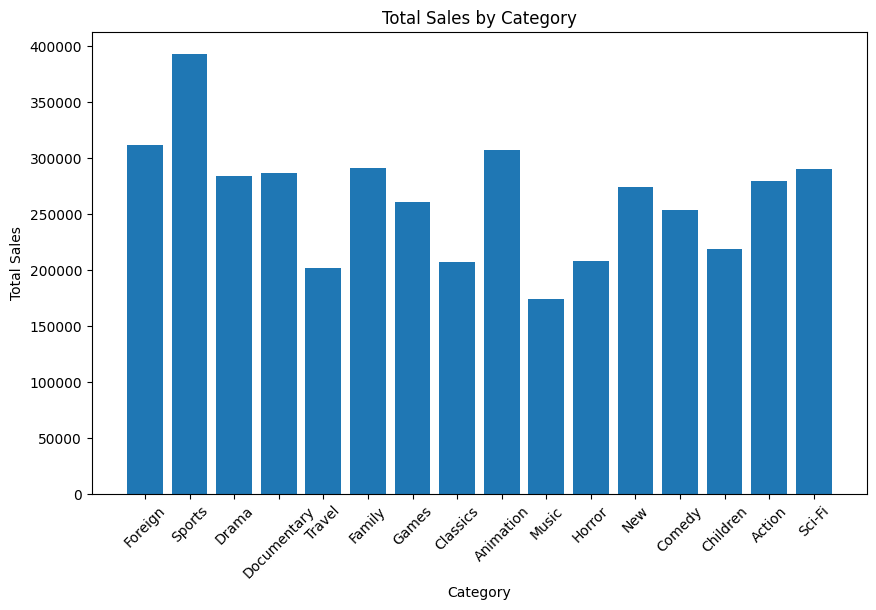

In [20]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
df_sales_category_pandas = df_sales_category_grouped.toPandas()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df_sales_category_pandas['category'], df_sales_category_pandas['sum(total_sales)'])
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Category')
plt.xticks(rotation=45)
plt.show()